In [ ]:
#1. Reto Dotar de “habilidades” a los monos
#Ejercicio voluntario (tiempo objetivo 2 semanas)
#Objetivo del ejercicio: Dotar de habilidades a los monos
#Los modos podrán invertir en un universo de 24.000 fondos de inversión (tendréis 5 años de histórico). 

#El ejercicio deberá realizarse en python. Tendréis que documentar 
#con suficiente detalle cómo planteáis la solución. No vale solo una propuesta, 
#debe entregarse código ejecutable. Tanto la propuesta como el código estará en el notebook. 

In [17]:
#INICIALIZO COMO SIEMPRE
import os 
os.chdir('C:\\Users\\Lenovo\\Programando')
os.getcwd() 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from datetime import datetime 
import pickle
from datetime import timedelta
#%%timeit
def inicializar_programa ():
    import os 
    os.chdir('C:\\Users\\Lenovo\\Programando')
    os.getcwd() 
    import numpy as np 
    import pandas as pd
    import matplotlib.pyplot as plt
    import itertools
    from datetime import datetime 
    import pickle
    from datetime import timedelta
    #%%timeit

inicializar_programa ()


In [18]:
#Descargo el nav quw es un diccionario y el MSCI que esta la data en string
def cargar_fichero_nav_MSCI ():
    import pickle
    with open('navs (1).pickle', 'rb') as f: #CUIDADO: navs (1).pickle
        stock_data = pickle.load(f)
        # 1.2 Pasarlo todo a un df con los valores de nav
    nav_dict = {tk: df.nav for tk,df in stock_data.items()}
    stock_nav = pd.DataFrame(nav_dict)
    stock_nav

    MSCI = pd.read_csv('MSCI.csv', 
                    header = 0,
                    index_col = 'Fecha')
    MSCI.index = pd.to_datetime(MSCI.index,format='%d.%m.%Y')

    #1.5 convertir MSCI.Último en numerico
    MSCI_Ultimo_s=pd.Series(MSCI.Último)
    s=MSCI_Ultimo_s
    f = []
    for item in s:
        a = item.replace(".", "")
        b = a.replace(",", ".")
        f.append(float(b))
    MSCI_Ultimo=pd.DataFrame(f,index=MSCI_Ultimo_s.index)
    MSCI_Ultimo.set_axis(['Último'], axis='columns', inplace=True)
    MSCI_Ultimo

    completo = pd.merge(stock_nav, MSCI_Ultimo, left_index=True, right_index=True)
    return completo
completo = cargar_fichero_nav_MSCI ()

#descargo el maestro pero no me ha dado tiempo a hacer clusters con la inforamcion que tiene
def cargar_fichero_maestro ():
    import pandas as pd
    maestro = pd.read_csv('maestro.csv')
    return maestro
maestro = cargar_fichero_maestro ()

In [19]:
#Homogeniza, sin quitar fondos/activos. Si hay algun fondo qeu no tiene nada en el periodo de tiempo, me lo quita
# Lo uso basicamente para homogeneizar todos los anos para hacer evaluaciones globales. 
def homogeizar(stock_nav_3):
    import numpy as np 
    import pandas as pd

    stock_nav_2 = stock_nav_3.dropna(axis=1,how='all')

    stock_nav_2 = stock_nav_2.dropna(how='all') # con esto quito los fines de semana

    stock_nav_2 = stock_nav_2.fillna(method='ffill')
    stock_nav_2 = stock_nav_2.fillna(method='bfill')

    return stock_nav_2


In [20]:
#esta es para cuando estoy calculando el rendimiento cuando invierto 
#y no cuando estoy calculando parametros por algoritmos para sacar pesos
def homogeizar_2(stock_nav_3,cuando_empezar,end_invertir):

    #stock_nav_2 = stock_nav_3.dropna(how='all') # con esto quito los fines de semana lo quito pq puede ser fondos que trabajen en fin de semana
    stock_nav_2 = stock_nav_3.fillna(method='ffill')
    stock_nav_2 = stock_nav_2.fillna(method='bfill')
    stock_nav_2 = stock_nav_2[cuando_empezar:end_invertir]
    return stock_nav_2


In [277]:
# Inversión aleatoria en N activos (deberá ser variable con cada mono). Parte 1


#funcion de aleatorios que me saque con que fondos (numero maximo de fondos y minimo de fondos)
#que ese mono va a trabajar pq segun lo ensenhado por profesor en programa frontera_markowitz
# Me salta por problemas de espacio en memoria cuando tengo muchos fondos con la mariz de covarianza

def generador_que_activos(datos_ordenados,max_n_testeos,min_n_fondos,max_n_fondos):

    fallido = 0
    import numpy as np 
    count = 0 # de mi cosecha para que no me de todo el rato "No se ha conseguido determinar los fondos a seccionar"
    for i in range (1,max_n_testeos):
        #datos_ordenados = stock_nav # esto lo he quitado pq luego me daba error
        num_activos = datos_ordenados.shape[1]
        aleatorios = np.random.randint(low=1, high=num_activos, size=num_activos)
        umbral = num_activos * 0.9 #0.99
        aleatorios[aleatorios<umbral] = 0
        aleatorios[aleatorios>=umbral] = 1
        
        if (aleatorios.sum() > min_n_fondos) and (aleatorios.sum() < max_n_fondos):
            break
        else :
                print("No se ha conseguido determinar los fondos a seccionar")
                count = count + 1 # de mi cosecha
                if count == 10: # de mi cosecha
                    fallido = 1
                    aleatorios = pd.Series(np.ones((datos_ordenados.shape[1]))) # de mi cosecha
                    #aleatorios = pd.Series(np.zeros((datos_ordenados.shape[1]))) # de mi cosecha
                    break # de mi cosecha

    return aleatorios,fallido





In [22]:
#Usando la funcion dada en reto 1 para la misma funcionalidad que en reto 1 solucion.
def generador_pesos(datos_ordenados, simulaciones = 10000):
    import random
    num_activos = datos_ordenados.shape[1]
    aleatorios = np.random.random((simulaciones,num_activos))

    umbral = 0.9998
    aleatorios[aleatorios<umbral] = 0

    # Buscamos y eliminamos las simulaciones que no tienen ningún activo seleccionado
    seleccion = ~(aleatorios.sum(axis=1) == 0)
    aleatorios = aleatorios[seleccion,:]

    # Asignamos los pesos a cada cartera
    # Para poder usar los aleatorios, dado que todos los activos seleccionados superan un umbral, debo restar el umbral
    # Si reescalase el peso, ningún activo de una cartera de 3 elementos superaría el 50% - 60% de peso. No puedo asignar los pesos reescalando.
    aleatorios[aleatorios!=0] = (aleatorios[aleatorios!=0] - umbral) * 10000

    for sim in range(aleatorios.shape[0]):

        vector_pesos = aleatorios[sim,:]    
        # posiciones = set(np.where(vector_pesos!=0)[0])
        posiciones = list(set(np.where(vector_pesos!=0)[0]))

        # Obtenemos el órden en el que vamos a asignar los pesos
        # posiciones_aleatorias = random.sample(posiciones, len(posiciones)) # random.sample está deprecado
        random.shuffle(posiciones)

        peso = 0
        # for pos in posiciones_aleatorias:
        for pos in posiciones:
            
            if peso < 1:
                peso += aleatorios[sim, pos]

                if peso > 1:            
                    exceso = peso - 1
                    aleatorios[sim, pos] = aleatorios[sim, pos] - exceso
                    peso = 1            

            elif peso == 1:
                aleatorios[sim, pos] = 0
    
    # En las carteras con 1 o 2 activos, no van a sumar siempre un 100% invertido. 
    # De cada 10.000 simulaciones, con un umbral de 0.9999 ocurre 600 - 700 veces. 
    # Con un unbral de 0.9998 de 1 a 5 veces.
    # Lo damos por bueno.
    
    return aleatorios
    

In [26]:
# Uso la funcion dada por el profesor en solucion Markowitz  reto 1 para la misma funcionalidad que en reto 1 con unos minimos cambios que he realizado 
# para cuadrarlo con el resto del programa

def frontera_markowitz_por_mi(datos_ordenados,num_simulaciones=100000):
    import matplotlib.pyplot as plt
    import itertools
    import random
# Inicializamos el valor de la cartera más eficiente y preparamos el gráfico de la frontera
    eficiencia_inicial = -100
    #plt.figure(figsize=(20,15)) 

# Markowitz en N activos (deberá ser variable con cada mono).
#Por eso paso el 
#num_bloques = int(np.ceil(num_simulaciones/10000))
#for bloque in range(num_bloques):
#aqui y asi siempre se hace las rentabilidades, matrices por cada mono y no solo los pesos son por cada mono
# Tambien Haga un aleatorio de los fondos a invertir. Primero defino aleatoriamente que activos y luego hago un df 
# con solo los activos sellecionados

    num_bloques = int(np.ceil(num_simulaciones/10000)) #movido
    aleatorios,fallido = generador_que_activos(datos_ordenados,1000,3,5000) #nuevo 
        
    datos_ordenados_2 =datos_ordenados.loc[:,datos_ordenados.columns[aleatorios == 1]] #nuevo
        
        #datos_ordenados_2 = solo_activos_seccionados (datos_ordenados,aleatorios) #nuevo
        #def solo_activos_seccionados (datos_ordenados,aleatorios):
        #    a= datos_ordenados.loc[:,datos_ordenados.columns[aleatorios == 1]]
        #    return a
    
# Calculamos la rentabilidad de los activos
    rent_activos = np.log(datos_ordenados_2).diff() #datos_ordenados es entrada. ya no es el datos_ordenados_2 mas pequeno
    rent_activos = rent_activos.iloc[1:,:]

# Calculamos la matriz de varianzas / covarianzas
    matriz_covarianzas = rent_activos.cov()
    matriz_covarianzas = matriz_covarianzas.to_numpy(dtype='float') 

# Calculamos la rentabilidad diaria del periodo para cada activo: LN(precio final/ precio inicial)/nº de datos
    precio_inicial = datos_ordenados_2.iloc[0,:]
    precio_final = datos_ordenados_2.iloc[-1,:]

    rentabilidad_diaria = np.log(precio_final / precio_inicial) / datos_ordenados_2.shape[0]

# num_bloques y for bloque estaba aqui antes

        # Sacamos la matriz de pesos para cada cartera
    matriz_pesos = generador_pesos(datos_ordenados_2, simulaciones = 10000)

        # Calculamos la rentabilidad de la cartera en función de los pesos 
    auxiliar = rentabilidad_diaria.values * matriz_pesos
    rentabilidad_carteras = auxiliar.sum(axis=1)

        # Calculamos el riesgo de la cartera (desviación), en función de los pesos
    auxiliar = np.dot(matriz_pesos, matriz_covarianzas) # Reutilizo la matriz auxiliar con 
        #otro propósito para no sobrecargar la RAM
    riesgo_carteras = pow((auxiliar * matriz_pesos).sum(axis=1), 0.5)

        # Hay que quitar outlayers: quantiles max de riesgo y quantiles minimos de rentabilidad
    filtro_riesgo = riesgo_carteras < np.percentile(riesgo_carteras, 99)
    riesgo_carteras = riesgo_carteras[filtro_riesgo]
    rentabilidad_carteras = rentabilidad_carteras[filtro_riesgo]

    filtro_rentabilidad = rentabilidad_carteras > np.percentile(rentabilidad_carteras, 1)
    riesgo_carteras = riesgo_carteras[filtro_rentabilidad]
    rentabilidad_carteras = rentabilidad_carteras[filtro_rentabilidad]

        # Calculamos la eficiencia de la cartera (pendiente), en función de los pesos
        # Existen posiciones que van a dar error, 0/0. Las localizo y hago que 0/1 = 0
    posiciones_0entre0 = (rentabilidad_carteras==0) * (riesgo_carteras==0)
    riesgo_carteras[posiciones_0entre0] = 0.0000001
    eficiencia_carteras = rentabilidad_carteras / riesgo_carteras

        # Localizamos la cartera con mayor eficiencia
    max_eficiencia = max(eficiencia_carteras)
        
    if max_eficiencia > eficiencia_inicial:

        posicion_cartera_eficiente = np.where(eficiencia_carteras == max_eficiencia)[0]
        cartera_eficiente = matriz_pesos[posicion_cartera_eficiente,:]    
        posicion_activos_eficientes = np.where(cartera_eficiente!=0)

        peso_activos_eficientes = cartera_eficiente[posicion_activos_eficientes]            
        isin_activos_eficientes = rent_activos.columns.values[posicion_activos_eficientes[1]]            
        eficiencia_inicial = max_eficiencia
        
        # Graficamos la frontera de Markowitz (riesgo y rentabilidad para cada vector de pesos)
        #print(f'Iteracion {bloque+1} de {num_bloques}')
        #plt.plot(riesgo_carteras,rentabilidad_carteras, 'o', color="b")
        
        

    # Dejamos bonito el gráfico y ajustamos la escala, para ver bien la frontera.
    #plt.xlabel("Riesgo")
    #plt.ylabel("Rentabilidad")

    #scale_factor = 3
    #xmin, xmax = plt.xlim()
    #ymin, ymax = plt.ylim()
    #plt.xlim(xmin * scale_factor, xmax * scale_factor)
    #plt.ylim(ymin * scale_factor/2, ymax * scale_factor/2)
    #plt.savefig('frontera_markowitz.png')

    return isin_activos_eficientes, peso_activos_eficientes, max_eficiencia # cuando solo quiero la mas eficiente
    


In [27]:
#Argumentación del sistema de generación de carteras para cada una de las habilidades (selección de activos y asignación de pesos). 
######Simpleemnte es que cada 30 dias va a invertir un numero aleatorio de fondos "aleatorios"  
# dando unos "pesos" aleatoriso para cada fondo que la suma de "dinero_disponible"
def mono_aleatorio (dinero_disponible_1, cuando_empezar_1):
    
    #inicializo variables
    dinero_disponible = dinero_disponible_1 # asi luego no me genera bucles al dispara el sub-programa varias veces
    cuando_empezar = cuando_empezar_1 # asi luego no me genera bucles al dispara el sub-programa varias veces
    dias =[] # lista de salida de la funcion. Lo necesito para luego pasarlo para gruardar salida y representar
    dinero_disponibles=[] # lista de salida de la funcion. Lo necesito para luego pasarlo para gruardar salida y representar
    
    for j in range (0,70): 
    #Se calculará el rendimiento obtenido para cada mono cada 30 días, se rebalanceará la cartera 
    #y se mantendrá el estilo de inversión que ya tenía asignado el mono.
    
        end_invertir = cuando_empezar + timedelta(days = 30)    # periodo seleccionado
        periodo = homogeizar(stock_nav[cuando_empezar:end_invertir]) # periodo homogeneizado
        aleatorios,fallido = generador_que_activos(periodo,1000,3, periodo.shape[1])# mono selecciona fondos. explicado al final del programa
        #Inversión aleatoria en N activos (deberá ser variable con cada mono)
        
        #print(aleatorios)

        periodo = periodo.loc[:,periodo.columns[aleatorios == 1]] # fondos selecciononado Vs dias seleccionados
        pesos = np.random.randint(low=1, high=100, size=periodo.shape[1]) # mono selecciona pesos
        porcentage_a_invertir = (pesos/pesos.sum())*dinero_disponible # mono distribuye pesos con el dinero disponible de misma cnatidad pro cada mono

    # Calculamos la rentabilidad diaria del periodo para cada activo: LN(precio final/ precio inicial)/nº de datos
        precio_inicial = periodo.iloc[0,:]
        precio_final = periodo.iloc[-1,:]
        rentabilidad_diaria = np.log(precio_final / precio_inicial) / periodo.shape[0]
        rentabilidad_diaria = rentabilidad_diaria + 1
        dinero_disponible = (rentabilidad_diaria * porcentage_a_invertir).sum()
        #print(dinero_disponible)
        
        #guardo en una lista todos los resultados pro interacion
        dias.append(end_invertir)
        dinero_disponibles.append(dinero_disponible)
        
        
        cuando_empezar = end_invertir + timedelta(days = 1) #ponemos un dia mas para empezar el siguiente periodo
        
        if cuando_empezar > stock_nav.index[-1]:
            break # para termianr el for y la funcion cuando la proxima interacion esta fuera de rangando de valores
    return dinero_disponibles,dias

In [28]:
#Argumentación del sistema de generación de carteras para cada una de las habilidades (selección de activos y asignación de pesos). 
#Parecida estructura a  la funcion mono_aleatorio 
def mono_Markowitz (dinero_disponible_1):

    dias =[]
    dinero_disponibles=[]
    
    cuando_empezar = stock_nav.index[0] #primer momento empezar
    end_invertir = cuando_empezar + timedelta(days = 366) # periodo seleccionado
    #La fecha de la inversión inicial ya no será aleatoria. Todos invertirán, por primera vez, 
    #el primer día del segundo año de datos disponibles (para que los monos dispongan de un histórico de datos, 
    #de máximo un año, para hacer los cálculos).
    
    
    datos_ordenados = homogeizar(stock_nav[cuando_empezar:end_invertir]) # periodo homogeneizado
    aleatorios,fallido = generador_que_activos(datos_ordenados,1000,3, datos_ordenados.shape[1]) # mono selecciona fondos como dice el enunciado
    #Markowitz en N activos (deberá ser variable con cada mono). Usarán 1 año de histórico para hacer los cálculos.

    datos_ordenados = datos_ordenados.loc[:,datos_ordenados.columns[aleatorios == 1]] # fondos selecciononado Vs dias selelcionados

    #Aplico Markpwitz del profesor
    isin_activos_eficientes, peso_activos_eficientes, max_eficiencia = frontera_markowitz_por_mi(datos_ordenados,num_simulaciones=100000)


    dinero_disponible = dinero_disponible_1
    cuando_empezar = end_invertir    
    
    for j in range (0,70): 
    #Se calculará el rendimiento obtenido para cada mono cada 30 días, se rebalanceará la cartera 
    #y se mantendrá el estilo de inversión que ya tenía asignado el mono.
    
    
        end_invertir = cuando_empezar + timedelta(days = 30)    # periodo seleccionado       
        
        periodo = stock_nav.loc[:,isin_activos_eficientes] # selecciono los fondos del isis mas eficiente segun Mark  # No para el isis, la verdad. para el numero de la columna; que es unico tambien.      
        
        #Me ha pasado que uno eficiente ya no estaba en el siguiente periodo. 
        #Pero eso no lo puedo saber cuando voy a invertir
        #entonces tengo que crear otra funcion homogeizar que no quite por columnas    
        periodo = homogeizar_2(periodo,cuando_empezar,end_invertir)
   
        
        pesos = peso_activos_eficientes # selecciono los pesos del los fondos mas eficiente segun Mark
        porcentage_a_invertir = (pesos/pesos.sum())*dinero_disponible # reparto el dinero disponble entre los fondos

        # Calculamos la rentabilidad diaria del periodo para cada activo: LN(precio final/ precio inicial)/nº de datos

        precio_inicial = periodo.iloc[0,:]
        precio_final = periodo.iloc[-1,:]
        rentabilidad_diaria = np.log(precio_final / precio_inicial) / periodo.shape[0]
        rentabilidad_diaria = rentabilidad_diaria + 1
        dinero_disponible = (rentabilidad_diaria * porcentage_a_invertir).sum()


        #guardar_resultador
        dias.append(end_invertir)
        dinero_disponibles.append(dinero_disponible)
        cuando_empezar = end_invertir + timedelta(days = 1) #ponemos un dia mas para empezar el siguiente periodo

        #calculo los nuevos fondos de Markowitz. desde el dia que deje de invertir empezando 1 ano antes
        end_mark = end_invertir #primer momento empezar
        start_mark = end_mark + timedelta(days = -365) # periodo seleccionado
        periodo = homogeizar(stock_nav[start_mark:end_mark]) # periodo homogeneizado
        aleatorios,fallido = generador_que_activos(periodo,1000,3, periodo.shape[1])#,aleatorios) # mono selecciona fondos como dice el enunciado
        #Markowitz en N activos (deberá ser variable con cada mono). Usarán 1 año de histórico para hacer los cálculos.
        

        periodo = periodo.loc[:,periodo.columns[aleatorios == 1]] # fondos selecciononado Vs dias sellecionados

        #hago la funcion de Markowitz
        isin_activos_eficientes, peso_activos_eficientes, max_eficiencia = frontera_markowitz_por_mi(periodo,num_simulaciones=100000)
       
        cuando_empezar = end_invertir + timedelta(days = 1) #ponemos un dia mas para empezar el siguiente periodo
        
        if cuando_empezar > stock_nav.index[-1]:
            break # salgo si el proximo periodo de tiempo esta fuera de rango de datos
    return dinero_disponibles,dias

In [29]:

def Alpha_de_Jensen(datos_ordenados_2,MSCI_2):
    #import time
    #start = time.process_time()

    # Generamos las rentabilidades logarítmicas para e índice, bono y activos.
    rent_activos = np.log(datos_ordenados_2).diff().dropna()
    rent_activos = rent_activos.iloc[1:,:] #NUEVO

    rent_MSCI = np.log(MSCI_2).diff().dropna()
    #hay que convertirlo a serie para que funcione la ecuacion de covarianza
    #rent_MSCI_S= pd.Series(rent_MSCI.iloc[:,0])
    rent_MSCI_S= pd.Series(rent_MSCI)


    rent_bund_S = pd.Series(np.zeros((rent_MSCI.shape[0])))
    rent_bund_S.index = rent_MSCI_S.index


    # Calculamos varianza, coovarianza y beta.
    # Aplicamos una rolling window de 10 días con la varianza como función
    varianza_MSCI = rent_MSCI_S.rolling(window=10).var() 
    #varianza_MSCI = rent_MSCI_S.rolling(window=120).var() 
    # Si con rollling de 10 dias me da taqnjto tiempo de ejecucion, No varia mucho si lo cambio a 12o dias

    #print("This time is being calculated")
    #end = time.process_time()
    #print(end - start)
    #start = time.process_time()
    
    
    
    ###########################################################################################################################################
    ###########################################################################################################################################
    ###########################################################################################################################################
    ###########################################################################################################################################
    # Aplicamos una rolling window de 10 días con la covarianza como función
    cov_act_ind = rent_MSCI_S.rolling(window=10).cov(rent_activos).dropna()  
    #####################ESTO TARDA 30 A 40 SEGUNDOS y el equivalente de apuntes profesor es menos de un segundo pq? ### ANTES 10
    # en esta covarianza me he quedado atascado varios dias. No se pq me da tantisimo tiempo de ejecuicion que me ha arruinado el resto del reto.
    ###########################################################################################################################################
    ###########################################################################################################################################
    ###########################################################################################################################################
    ###########################################################################################################################################


    #print("This time is being calculated")
    #end = time.process_time()
    #print(end - start)
    #start = time.process_time()


    # Calculamos la Beta
    beta = cov_act_ind.div(varianza_MSCI, axis=0) # Dividimos todas las columnas por la Serie de la varianza

    # Calculamos el Alpha del activo. α=Rc-(Rf+β(Rm-Rf))
    alpha_activos = rent_activos - beta.mul((rent_MSCI_S - rent_bund_S), axis=0).add(rent_bund_S, axis=0)
    alpha_activos.dropna(inplace=True) # Eliminamos los primeros valores NaN

    #print("This time is being calculated")
    #end = time.process_time()
    #print(end - start)

    return alpha_activos



In [30]:
# Argumentación del sistema de generación de carteras para cada una de las habilidades (selección de activos y asignación de pesos). 
# Estructura equuivalente a la de lso otros monos
def mono_Alpha_de_Jensen (dinero_disponible_1):
    dias =[]
    dinero_disponibles=[]
    
    
    dinero_disponible = dinero_disponible_1
    cuando_empezar_1 = stock_nav.index[0] + timedelta(days = 366)
    #La fecha de la inversión inicial ya no será aleatoria. Todos invertirán, por primera vez, 
    #el primer día del segundo año de datos disponibles (para que los monos dispongan de un histórico de datos, 
    #de máximo un año, para hacer los cálculos).
    cuando_empezar = cuando_empezar_1
    

    for j in range (0,70):
    #Se calculará el rendimiento obtenido para cada mono cada 30 días, se rebalanceará la cartera 
    #y se mantendrá el estilo de inversión que ya tenía asignado el mono.
        
        
        end_periodo_muestreo = cuando_empezar
        start_periodo_muestreo = end_periodo_muestreo - timedelta(days = 120)
        datos_ordenados_2 = homogeizar(stock_nav[start_periodo_muestreo:end_periodo_muestreo])


        MSCI_2= MSCI[start_periodo_muestreo:end_periodo_muestreo]

        alpha_activos =Alpha_de_Jensen(datos_ordenados_2,MSCI_2)
        fondos = datos_ordenados_2.columns[alpha_activos.iloc[-1,] > 0]
        
        #Alpha de Jensen: invertirá en N fondos (deberá ser variable con cada mono) 
        #que tengan Alpha positiva en relación con el MSCI. La ventana de datos con la que 
        #hacer el cálculo será de 120 días para cada mono.
        
        aleatorios,fallido = generador_que_activos(stock_nav.loc[:,fondos],1000,3, stock_nav.loc[:,fondos].shape[1])
        
             
        periodo = stock_nav.loc[:,stock_nav.loc[:,fondos].columns[aleatorios == 1]] # fondos selecciononado para invertir 
        periodo = homogeizar(periodo) # esto se podria quitar 
        end_invertir = cuando_empezar + timedelta(days = 30)    # periodo seleccionado
        periodo = periodo[cuando_empezar:end_invertir] # periodo homogeneizado y seleccionado. En este orden por si da ese activo estaba en nan en todo el periodo

        #cuanto invertir en cada activo. No me complico la vida. lo mismo para todos los fondos. Pero se podria mejorar si tuviera mas tiempo.
        #pesos = pd.Series(1 / periodo.columns.shape[0], index=range(periodo.shape[1]))
        #porcentage_a_invertir = pesos * dinero_disponible
        porcentage_a_invertir = dinero_disponible/periodo.columns.shape[0]

        precio_inicial = periodo.iloc[0,:]
        precio_final = periodo.iloc[-1,:]
        rentabilidad_diaria = np.log(precio_final / precio_inicial) / periodo.shape[0]
        rentabilidad_diaria = rentabilidad_diaria + 1

        dinero_disponible = (rentabilidad_diaria * porcentage_a_invertir).sum()

        dias.append(end_invertir)
        dinero_disponibles.append(dinero_disponible)
        cuando_empezar = end_invertir + timedelta(days = 1) #ponemos un dia mas para empezar el siguiente periodo
        
        #print("This time is being calculated")
        #end = time.process_time()
        #print(end - start)

        if cuando_empezar > stock_nav.index[-1]:
                break

    
    return dinero_disponibles,dias



In [250]:
def Sharpe(datos_ordenados_2,MSCI_2):
    
    # Generamos las rentabilidades logarítmicas para e índice, bono y activos.
    rent_activos = np.log(datos_ordenados_2).diff().dropna()

    rent_MSCI = np.log(MSCI_2).diff().dropna()
    #hay que convertirlo a serie para que funcione la ecuacion de covarianza

    rent_MSCI_S= pd.Series(rent_MSCI)


    std_ret = datos_ordenados_2.rolling(90).std(ddof=0)


    # Calculamos el ratio de Sharpe
    #sharpe_activos = (rent_activos - rent_MSCI) / std_ret
    # el ultimo dia tuve que cambiarlo a la linea de abajo pq el programa me fallo y no se pq me fallo.
    sharpe_activos = rent_activos.sub(rent_MSCI_S, axis=0).div(std_ret)

    
    return sharpe_activos,rent_activos,rent_MSCI,std_ret



In [269]:
#Argumentación del sistema de generación de carteras para cada una de las habilidades (selección de activos y asignación de pesos). 
# Equivalente estructura que en las otras fuciones de los otros monos
def mono_Sharpe (dinero_disponible_1):
    dias =[]
    dinero_disponibles=[]


    dinero_disponible = dinero_disponible_1
    cuando_empezar_1 = stock_nav.index[0] + timedelta(days = 366) 
    #La fecha de la inversión inicial ya no será aleatoria. Todos invertirán, por primera vez, 
    #el primer día del segundo año de datos disponibles (para que los monos dispongan de un histórico de datos, 
    #de máximo un año, para hacer los cálculos).
    
    cuando_empezar = cuando_empezar_1

    for j in range (0,70):
    #Se calculará el rendimiento obtenido para cada mono cada 30 días, se rebalanceará la cartera 
    #y se mantendrá el estilo de inversión que ya tenía asignado el mono.

        end_periodo_muestreo = cuando_empezar
        start_periodo_muestreo = end_periodo_muestreo - timedelta(days = 150)
        datos_ordenados_2 = homogeizar(stock_nav[start_periodo_muestreo:end_periodo_muestreo])


        MSCI_2= MSCI[start_periodo_muestreo:end_periodo_muestreo]

        
        
        #sharpe_activos,rent_activos,rent_MSCI,std_ret = Sharpe(datos_ordenados_2,MSCI_2)
        # No se pq pero no me lee (que me ha sucedido el ultimo dia) que vaya a la funcion Sharpe cuando esta bien definida
        # lo qaue hace la funcion Sharpe, esta copiado aqui abajo y funciona
        # Generamos las rentabilidades logarítmicas para e índice, bono y activos.
        rent_activos = np.log(datos_ordenados_2).diff().dropna()
        rent_MSCI = np.log(MSCI_2).diff().dropna()
        #hay que convertirlo a serie para que funcione la ecuacion de covarianza
        rent_MSCI_S= pd.Series(rent_MSCI)
        std_ret = datos_ordenados_2.rolling(90).std(ddof=0)
        # Calculamos el ratio de Sharpe
        #sharpe_activos = (rent_activos - rent_MSCI) / std_ret
        sharpe_activos = rent_activos.sub(rent_MSCI_S, axis=0).div(std_ret)
        
        

        fondos = datos_ordenados_2.columns[sharpe_activos.iloc[-1,] > 0]


        aleatorios,fallido = generador_que_activos(stock_nav.loc[:,fondos],1000,3, stock_nav.loc[:,fondos].shape[1])
        #Sharpe: invertirá en N fondos (deberá ser variable con cada mono), que tengan un ratio de Sharpe mayor a un umbral de 0. 
        #La ventana de datos con la que hacer el cálculo será de 90 días para cada mono.
        
        if fallido == 0:
            periodo = stock_nav.loc[:,stock_nav.loc[:,fondos].columns[aleatorios == 1]] # fondos selecciononado para invertir 
        if fallido == 1:
            periodo = stock_nav.loc[:,stock_nav.loc[:,fondos].columns]

        periodo = homogeizar(periodo) # periodo homogeneizado pq puede ser que alguno de los eleguidos # esto se podria quitar 
        end_invertir = cuando_empezar + timedelta(days = 30)    # periodo seleccionado
        periodo = periodo[cuando_empezar:end_invertir] # periodo homogeneizado y sellecionado. En este orden por si da ese activo estaba en nan en todo el periodo

        #cuanto invertir en cada activo. No me complico la vida. lo mismo para todos los fondos. Se podria mejorar

        porcentage_a_invertir = dinero_disponible/periodo.columns.shape[0]



        precio_inicial = periodo.iloc[0,:]
        precio_final = periodo.iloc[-1,:]
        rentabilidad_diaria = np.log(precio_final / precio_inicial) / periodo.shape[0]
        rentabilidad_diaria = rentabilidad_diaria + 1

        dinero_disponible = (rentabilidad_diaria * porcentage_a_invertir).sum()

        dias.append(end_invertir)
        dinero_disponibles.append(dinero_disponible)
        cuando_empezar = end_invertir + timedelta(days = 1) #ponemos un dia mas para empezar el siguiente periodo

        if cuando_empezar > stock_nav.index[-1]:
                break

    

    return dinero_disponibles,dias




Sharpe
1
This time is being calculated
186.953125
Alpha_de_Jensen
2
This time is being calculated
4224.953125
Markowitz
3
This time is being calculated
28.125
Alpha_de_Jensen
4
This time is being calculated
3928.625
Markowitz
5
This time is being calculated
28.796875
Markowitz
6
This time is being calculated
28.65625
Alpha_de_Jensen
7
This time is being calculated
3928.6875
Alpha_de_Jensen
8
This time is being calculated
4213.015625
Alpha_de_Jensen
9
This time is being calculated
3387.78125
Sharpe
10
This time is being calculated
203.46875
Alpha_de_Jensen
11
This time is being calculated
3059.96875
Aleatorio
12
This time is being calculated
1.40625
Aleatorio
13
This time is being calculated
1.421875
Aleatorio
14
This time is being calculated
1.40625
Sharpe
15
This time is being calculated
175.421875
Aleatorio
16
This time is being calculated
1.921875
Aleatorio
17
This time is being calculated
1.875
Markowitz
18
This time is being calculated
28.84375
Markowitz
19
This time is being calc

<AxesSubplot:>

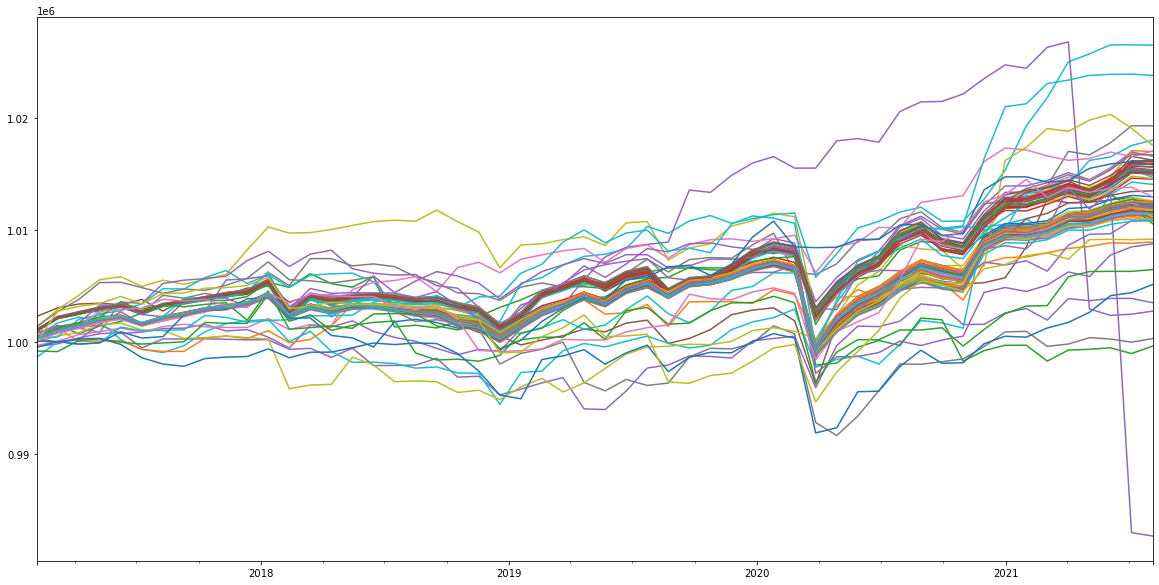

In [273]:
#PROGRAMA main()
from datetime import timedelta
import numpy as np 
import pandas as pd
from datetime import timedelta
import time

#Por si se quiere cargarlo desde una celda todo
#inicializar_programa ()
#completo = cargar_fichero_nav_MSCI ()
#maestro = cargar_fichero_maestro ()


MSCI = completo.iloc[:,-1]
stock_nav = completo.iloc[:,0:-1]

import random
from random import randrange, choice
opciones =[1,2,3,4]
Aleatorio = [] #1 = Inversión aleatoria en N activos
Alpha = [] #2 = Alpha de Jensen: invertirá en N fondos (deberá ser variable con cada mono) que tengan Alpha positiva en relación con el MSCI.
Sharpe = [] #3 = Sharpe: invertirá en N fondos (deberá ser variable con cada mono), que tengan un ratio de Sharpe mayor a un umbral de 0
Markowitz = [] #4 = Markowitz en N activos 

num_simulaciones = 100
#El número de simulaciones realizadas: se deberá alcanzar los 100 millones de monos.
#### Por culpa del tiempo de ejecucion de la covarianza de la funcion Alpha_de_Jensen, que tarda unos 40 segundos, no me podido ni hacercarme 
# al numero de monos que pedia el enunciado. No se como reducirlo en tiempo si tocar en numero de fondos a incluir en esa covarianza.
# Ademas aleatorio me tardaba 1.5 segundos a 2 segundos. Asi que con mi ordenador no podria alcanzar 70 simulaciones completas por minuto.
# Guillermo me dijo una vez por email qeu el multiprocessign no iba bien en Python; o eso recuerdo.





contador = 0

start = time.process_time()

dinero_disponible_1 = 1000000 #dinero disponible
cuando_empezar_1 = stock_nav.index[0] + timedelta(days = 366)
    #La fecha de la inversión inicial ya no será aleatoria. Todos invertirán, por primera vez, 
    #el primer día del segundo año de datos disponibles (para que los monos dispongan de un histórico de datos, 
    #de máximo un año, para hacer los cálculos). Solo para Aleatorio
    
    
for i in range(0,num_simulaciones):
    seleccionado = random.choice(opciones)
    
    #A cada modo se le asignará al "nacer", de manera aleatoria, una de las siguientes formas de invertir:

    if seleccionado == 1:
        print('Aleatorio')
        print(i+1)
        dinero_disponibles,dias = mono_aleatorio (dinero_disponible_1, cuando_empezar_1)
        Aleatorio.append(dinero_disponibles[-1])
        print("This time is being calculated")
        end = time.process_time()
        print(end - start)
        start = time.process_time()
        
    if seleccionado == 2:
        print('Alpha_de_Jensen')
        print(i+1)
        dinero_disponibles,dias = mono_Alpha_de_Jensen (dinero_disponible_1)
        Alpha.append(dinero_disponibles[-1])
        print("This time is being calculated")
        end = time.process_time()
        print(end - start)
        start = time.process_time()
        
    if seleccionado == 3:
        print('Sharpe')
        print(i+1)
        #dinero_disponibles,dias = mono_Sharpe (dinero_disponible_1)
        dinero_disponibles,dias  = mono_Sharpe (dinero_disponible_1)
        Sharpe.append(dinero_disponibles[-1])
        print("This time is being calculated")
        end = time.process_time()
        print(end - start)
        start = time.process_time()
        
    if seleccionado == 4:
        print('Markowitz')
        print(i+1)
        dinero_disponibles,dias = mono_Markowitz (dinero_disponible_1)
        Markowitz.append(dinero_disponibles[-1])
        print("This time is being calculated")
        end = time.process_time()
        print(end - start)
        start = time.process_time()
        
    #Aleatorio,dinero_disponibles,dias

    if contador == 0:
        guardar_resultador_df = pd.DataFrame(dinero_disponibles)#para representar
        guardar_resultador_df.index = pd.to_datetime(dias,format='%Y.%m.%d') #para representar
        contador = 1
    else:
        aux = pd.DataFrame(dinero_disponibles)
        aux.index = pd.to_datetime(dias,format='%Y.%m.%d')        
        contador = contador + 1
        aux.rename(columns={0: contador}, inplace=True) # tengo que hacer esto pq al hacer append, me lo hacia llamando la comuna como 0 y luego me saltaba fallo.
        
        #guardar_resultador_df.merge(aux)
        guardar_resultador_df = pd.merge(guardar_resultador_df, aux, left_index=True, right_index=True)
        
        


#para representar
guardar_resultador_df.iloc[:,:].plot(figsize = (20,10),legend = None)


#El tiempo de ejecución: debéis conocer el tiempo de ejecución y mostrarlo junto con la tabla anterior 
#(es decir, debe ser ejecutable, aunque dure varias horas). Se mostrará el tiempo de ejecución del 
#script junto con la tabla de arriba. Más de 24h no es admisible.
#### Ni me he podido acercar a 100 millones de simulaciones pq no he podido resolver el tiempo de ejecucion de la covarianza 
# de la funcion Alpha_de_Jensen y pq ya solo con aleatorio tardaba 1,5 segundos ese mono; y entiende que no se deerai bajar de 20000 fondos.

In [275]:
#Los guardo por si acaso ya que el programa va muy lento; como me ha pasado dos dias antes del final de entrega del reto
Aleatorio_S = pd.Series(Aleatorio) 
Alpha_S = pd.Series(Alpha)
Sharpe_S = pd.Series(Sharpe)
Markowitz_S = pd.Series(Markowitz)

Aleatorio_S.to_csv('Aleatorio.csv')
Alpha_S.to_csv('Alpha.csv')
Sharpe_S.to_csv('Sharpe.csv')
Markowitz_S.to_csv('Markowitz.csv')

In [276]:
#La consecución del objetivo solicitado (añadir las habilidades): debéis mostrar una tabla con la distribución 
#de las rentabilidades obtenidas por habilidad y en global (como la tabla de abajo). Sin la tabla no se valorará el ejercicio. 
#Graficar resultados
indice = ['0.0%','5.0%','10.0%','15.0%','20.0%', '25.0%','30.0%', '35.0%','40.0%', '45.0%','50.0%', '55.0%','60.0%', '65.0%','70.0%', '75.0%','80.0%', '85.0%','90.0%', '95.0%','100.0%']
titulos = ['Aleatorio','Alpha','Sharpe','Markowitz','Global']
resultados = pd.DataFrame(np.zeros((21,5)),index = indice, columns = titulos)

import locale

resultados.iloc[0,0]=(np.percentile(Aleatorio, 0)-1000000)/1000000
resultados.iloc[1,0]=(np.percentile(Aleatorio, 5)-1000000)/1000000
resultados.iloc[2,0]=(np.percentile(Aleatorio, 10)-1000000)/1000000
resultados.iloc[3,0]=(np.percentile(Aleatorio, 15)-1000000)/1000000
resultados.iloc[4,0]=(np.percentile(Aleatorio, 20)-1000000)/1000000
resultados.iloc[5,0]=(np.percentile(Aleatorio, 25)-1000000)/1000000
resultados.iloc[6,0]=(np.percentile(Aleatorio, 30)-1000000)/1000000
resultados.iloc[7,0]=(np.percentile(Aleatorio, 35)-1000000)/1000000
resultados.iloc[8,0]=(np.percentile(Aleatorio, 40)-1000000)/1000000
resultados.iloc[9,0]=(np.percentile(Aleatorio, 45)-1000000)/1000000
resultados.iloc[10,0]=(np.percentile(Aleatorio, 50)-1000000)/1000000
resultados.iloc[11,0]=(np.percentile(Aleatorio, 55)-1000000)/1000000
resultados.iloc[12,0]=(np.percentile(Aleatorio, 60)-1000000)/1000000
resultados.iloc[13,0]=(np.percentile(Aleatorio, 65)-1000000)/1000000
resultados.iloc[14,0]=(np.percentile(Aleatorio, 70)-1000000)/1000000
resultados.iloc[15,0]=(np.percentile(Aleatorio, 75)-1000000)/1000000
resultados.iloc[16,0]=(np.percentile(Aleatorio, 80)-1000000)/1000000
resultados.iloc[17,0]=(np.percentile(Aleatorio, 85)-1000000)/1000000
resultados.iloc[18,0]=(np.percentile(Aleatorio, 90)-1000000)/1000000
resultados.iloc[19,0]=(np.percentile(Aleatorio, 95)-1000000)/1000000
resultados.iloc[20,0]=(np.percentile(Aleatorio, 100)-1000000)/1000000

resultados.iloc[0,1]=(np.percentile(Alpha, 0)-1000000)/1000000
resultados.iloc[1,1]=(np.percentile(Alpha, 5)-1000000)/1000000
resultados.iloc[2,1]=(np.percentile(Alpha, 10)-1000000)/1000000
resultados.iloc[3,1]=(np.percentile(Alpha, 15)-1000000)/1000000
resultados.iloc[4,1]=(np.percentile(Alpha, 20)-1000000)/1000000
resultados.iloc[5,1]=(np.percentile(Alpha, 25)-1000000)/1000000
resultados.iloc[6,1]=(np.percentile(Alpha, 30)-1000000)/1000000
resultados.iloc[7,1]=(np.percentile(Alpha, 35)-1000000)/1000000
resultados.iloc[8,1]=(np.percentile(Alpha, 40)-1000000)/1000000
resultados.iloc[9,1]=(np.percentile(Alpha, 45)-1000000)/1000000
resultados.iloc[10,1]=(np.percentile(Alpha, 50)-1000000)/1000000
resultados.iloc[11,1]=(np.percentile(Alpha, 55)-1000000)/1000000
resultados.iloc[12,1]=(np.percentile(Alpha, 60)-1000000)/1000000
resultados.iloc[13,1]=(np.percentile(Alpha, 65)-1000000)/1000000
resultados.iloc[14,1]=(np.percentile(Alpha, 70)-1000000)/1000000
resultados.iloc[15,1]=(np.percentile(Alpha, 75)-1000000)/1000000
resultados.iloc[16,1]=(np.percentile(Alpha, 80)-1000000)/1000000
resultados.iloc[17,1]=(np.percentile(Alpha, 85)-1000000)/1000000
resultados.iloc[18,1]=(np.percentile(Alpha, 90)-1000000)/1000000
resultados.iloc[19,1]=(np.percentile(Alpha, 95)-1000000)/1000000
resultados.iloc[20,1]=(np.percentile(Alpha, 100)-1000000)/1000000

resultados.iloc[0,2]=(np.percentile(Sharpe, 0)-1000000)/1000000
resultados.iloc[1,2]=(np.percentile(Sharpe, 5)-1000000)/1000000
resultados.iloc[2,2]=(np.percentile(Sharpe, 10)-1000000)/1000000
resultados.iloc[3,2]=(np.percentile(Sharpe, 15)-1000000)/1000000
resultados.iloc[4,2]=(np.percentile(Sharpe, 20)-1000000)/1000000
resultados.iloc[5,2]=(np.percentile(Sharpe, 25)-1000000)/1000000
resultados.iloc[6,2]=(np.percentile(Sharpe, 30)-1000000)/1000000
resultados.iloc[7,2]=(np.percentile(Sharpe, 35)-1000000)/1000000
resultados.iloc[8,2]=(np.percentile(Sharpe, 40)-1000000)/1000000
resultados.iloc[9,2]=(np.percentile(Sharpe, 45)-1000000)/1000000
resultados.iloc[10,2]=(np.percentile(Sharpe, 50)-1000000)/1000000
resultados.iloc[11,2]=(np.percentile(Sharpe, 55)-1000000)/1000000
resultados.iloc[12,2]=(np.percentile(Sharpe, 60)-1000000)/1000000
resultados.iloc[13,2]=(np.percentile(Sharpe, 65)-1000000)/1000000
resultados.iloc[14,2]=(np.percentile(Sharpe, 70)-1000000)/1000000
resultados.iloc[15,2]=(np.percentile(Sharpe, 75)-1000000)/1000000
resultados.iloc[16,2]=(np.percentile(Sharpe, 80)-1000000)/1000000
resultados.iloc[17,2]=(np.percentile(Sharpe, 85)-1000000)/1000000
resultados.iloc[18,2]=(np.percentile(Sharpe, 90)-1000000)/1000000
resultados.iloc[19,2]=(np.percentile(Sharpe, 95)-1000000)/1000000
resultados.iloc[20,2]=(np.percentile(Sharpe, 100)-1000000)/1000000

resultados.iloc[0,3]=(np.percentile(Markowitz, 0)-1000000)/1000000
resultados.iloc[1,3]=(np.percentile(Markowitz, 5)-1000000)/1000000
resultados.iloc[2,3]=(np.percentile(Markowitz, 10)-1000000)/1000000
resultados.iloc[3,3]=(np.percentile(Markowitz, 15)-1000000)/1000000
resultados.iloc[4,3]=(np.percentile(Markowitz, 20)-1000000)/1000000
resultados.iloc[5,3]=(np.percentile(Markowitz, 25)-1000000)/1000000
resultados.iloc[6,3]=(np.percentile(Markowitz, 30)-1000000)/1000000
resultados.iloc[7,3]=(np.percentile(Markowitz, 35)-1000000)/1000000
resultados.iloc[8,3]=(np.percentile(Markowitz, 40)-1000000)/1000000
resultados.iloc[9,3]=(np.percentile(Markowitz, 45)-1000000)/1000000
resultados.iloc[10,3]=(np.percentile(Markowitz, 50)-1000000)/1000000
resultados.iloc[11,3]=(np.percentile(Markowitz, 55)-1000000)/1000000
resultados.iloc[12,3]=(np.percentile(Markowitz, 60)-1000000)/1000000
resultados.iloc[13,3]=(np.percentile(Markowitz, 65)-1000000)/1000000
resultados.iloc[14,3]=(np.percentile(Markowitz, 70)-1000000)/1000000
resultados.iloc[15,3]=(np.percentile(Markowitz, 75)-1000000)/1000000
resultados.iloc[16,3]=(np.percentile(Markowitz, 80)-1000000)/1000000
resultados.iloc[17,3]=(np.percentile(Markowitz, 85)-1000000)/1000000
resultados.iloc[18,3]=(np.percentile(Markowitz, 90)-1000000)/1000000
resultados.iloc[19,3]=(np.percentile(Markowitz, 95)-1000000)/1000000
resultados.iloc[20,3]=(np.percentile(Markowitz, 100)-1000000)/1000000

Global = Aleatorio + Alpha + Sharpe + Markowitz

resultados.iloc[0,4]=(np.percentile(Global, 0)-1000000)/1000000
resultados.iloc[1,4]=(np.percentile(Global, 5)-1000000)/1000000
resultados.iloc[2,4]=(np.percentile(Global, 10)-1000000)/1000000
resultados.iloc[3,4]=(np.percentile(Global, 15)-1000000)/1000000
resultados.iloc[4,4]=(np.percentile(Global, 20)-1000000)/1000000
resultados.iloc[5,4]=(np.percentile(Global, 25)-1000000)/1000000
resultados.iloc[6,4]=(np.percentile(Global, 30)-1000000)/1000000
resultados.iloc[7,4]=(np.percentile(Global, 35)-1000000)/1000000
resultados.iloc[8,4]=(np.percentile(Global, 40)-1000000)/1000000
resultados.iloc[9,4]=(np.percentile(Global, 45)-1000000)/1000000
resultados.iloc[10,4]=(np.percentile(Global, 50)-1000000)/1000000
resultados.iloc[11,4]=(np.percentile(Global, 55)-1000000)/1000000
resultados.iloc[12,4]=(np.percentile(Global, 60)-1000000)/1000000
resultados.iloc[13,4]=(np.percentile(Global, 65)-1000000)/1000000
resultados.iloc[14,4]=(np.percentile(Global, 70)-1000000)/1000000
resultados.iloc[15,4]=(np.percentile(Global, 75)-1000000)/1000000
resultados.iloc[16,4]=(np.percentile(Global, 80)-1000000)/1000000
resultados.iloc[17,4]=(np.percentile(Global, 85)-1000000)/1000000
resultados.iloc[18,4]=(np.percentile(Global, 90)-1000000)/1000000
resultados.iloc[19,4]=(np.percentile(Global, 95)-1000000)/1000000
resultados.iloc[20,4]=(np.percentile(Global, 100)-1000000)/1000000
resultados.iloc[20,4]=(np.percentile(Global, 100)-1000000)/1000000



resultados


,Aleatorio,Alpha,Sharpe,Markowitz,Global
0.0%,0.010819,0.010848,0.014552,-0.017295,-0.017295
5.0%,0.011038,0.010888,0.014636,-0.000278,0.005073
10.0%,0.011166,0.011211,0.014807,0.000818,0.010451
15.0%,0.011221,0.011383,0.014929,0.003007,0.011052
20.0%,0.011305,0.011538,0.014975,0.004181,0.011248
25.0%,0.011313,0.011640,0.015116,0.005821,0.011410
30.0%,0.011419,0.011669,0.015144,0.007867,0.011585
35.0%,0.011483,0.011783,0.015258,0.008906,0.011652
40.0%,0.011574,0.011848,0.015312,0.009162,0.011796
45.0%,0.011612,0.011884,0.015374,0.010451,0.011867


In [ ]:
#Preguntas que debes hacerte, resolver y argumentar con detalle en el inicio del script:
#    • Los activos no tienen los mismos días cotizados, ¿cómo los homogeneizamos?

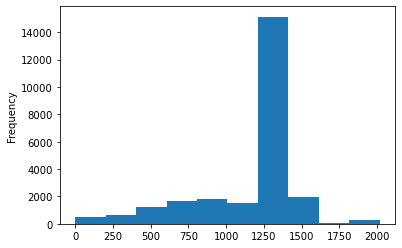

In [13]:
#Solo para ver como es stock_nav
#cuantos nan hay por fondo
fondos_n_nan = stock_nav.isna().sum()
p=fondos_n_nan.sort_values(ascending=True)
#p.plot.hist()

# el numero de dias que cada fondo ha cotizado
fondo_dia = stock_nav.count(axis=0)
p=fondo_dia.sort_values(ascending=True)
p.plot.hist()

#cuantos nan hay por dia
dias_n_nan = stock_nav.isna().sum(axis=1)
p=dias_n_nan.sort_values(ascending=True)
#p.plot.hist()

#el numero de fondos que ha cotizado cada dia
dia_fondo = stock_nav.count(axis=1)
p=dia_fondo.sort_values(ascending=True)
#p.plot.hist()

Text(0, 0.5, 'numero de dias que el fondo esta cotizado')

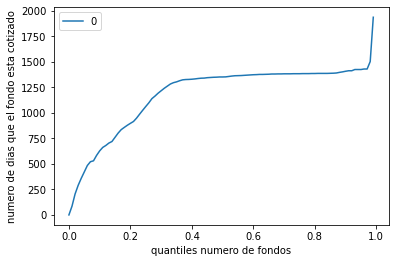

In [14]:
#Solo para ver como es stock_nav
# el numero de dias que cada fondo ha cotizado
def as_list(x):
    if type(x) is list:
        return x
    else:
        return [x]
    
p2=[]
for i in np.arange(0, 1, 0.01): 
     p2.append(as_list(fondo_dia.quantile(q=i)))
p2_df = pd.DataFrame(p2,index=np.arange(0, 1, 0.01))
p2_df.plot()
plt.xlabel('quantiles numero de fondos')
plt.ylabel('numero de dias que el fondo esta cotizado')

# Mi conclusion es no borrar ningun dia ya que parece que todos los dias hay algun fondo cotizando

Text(0, 0.5, 'numero de fondos que el dia tiene cotizando')

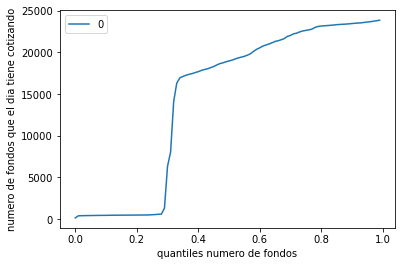

In [15]:
#Solo para ver como es stock_nav
#el numero de fondos que ha cotizado cada dia
def as_list(x):
    if type(x) is list:
        return x
    else:
        return [x]
    
p2=[]
for i in np.arange(0, 1, 0.01): 
     p2.append(as_list(dia_fondo.quantile(q=i)))
p2_df = pd.DataFrame(p2,index=np.arange(0, 1, 0.01))
p2_df.plot()
plt.xlabel('quantiles numero de fondos')
plt.ylabel('numero de fondos que el dia tiene cotizando')
# Mi conclusion seria que habria que reducir el numero de dias a un quantil 0.3 pq casi no han tenido fondos cotizando.
# Esos dias son los que me salen por dia_fondo.quantile(q=0.28); que son 1291 dias de un total de stock_nav 2020
# En el programa de arriba no lo he quitadeo pq queria ver cuanto reaccionaba cada algoritmo de inversion en tiempo de ejecucion
# El problema, que no he sabido como solucionar el el Alpha de Jensen que no entiendo pq tandata cada covarianza 40 segundos
# Y no he podido solucionarlo. Y con el tiempo que he podiso destinar a este reto, no he podido mejorar la ejecucion del resto de algoritms
# pero al reducir el numero de fondos, algo se podria reducir de tiempo.
# Pero si la ilversion con numero aleatorios me tarde casi dos segundos, con mi ordenador no veo como podria alcanzar 100 millones de simulaciones
# en 1 dia como maximo. Eso es como 70 simulaciones por minuto. 

In [ ]:
#    • Hay días en los que la mayoría de los activos no tienen cotización ¿qué hacemos?
# Explicado en el punto anterior. Yo lo que haria es hacer es quitar los dias con dia_fondo.quantile(q=0.28)


In [ ]:
#    • ¿Con cuántos activos nos quedamos y por qué? En ningún caso se podrá trabajar con menos de 20.000 FI.
# No lo he podido desarroyar. Pero yo haria clusters como se nos ha explicado en las clases:
    #- Cluster por correlaciones: d[Xi,Xj]=((1-corr(i,j))/2)*0.5
    #- Cluster por tipo de fondo (segun fichero maestro): geo_zone Vs class_code. No incluyo el asset_type pq no se que representa
#No he echo clusters pq el enuncuado decia no reducir a menso de 20.000 fondos. Pero yo creo que se podria hacer clusters por tipo de fondos y 
# luego seleccionar o eliminar los que tuvuieran correlaciones Vs volatilidades muy parecidas.    

In [ ]:
#    • Para cada una de las habilidades: 
#        ◦ ¿Cuántos activos seleccionamos y cómo los seleccionamos? Por ejemplo, para un mono que invierte en función de Sharpe, 
#¿cómo construyes la cartera?, ¿conoces el universo de activos elegibles en cada instante de tiempo? Argumenta, con detalle, 
#cómo construyes la cartera para cada una de las habilidades.
# Pues lo que he echo es como se ve en la celda titulada #PROGRAMA main():
# opciones =[1,2,3,4]
# Aleatorio = [] #1 = Inversión aleatoria en N activos
# Alpha = [] #2 = Alpha de Jensen: invertirá en N fondos (deberá ser variable con cada mono) que tengan Alpha positiva en relación con el MSCI.
# Sharpe = [] #3 = Sharpe: invertirá en N fondos (deberá ser variable con cada mono), que tengan un ratio de Sharpe mayor a un umbral de 0
# Markowitz = [] #4 = Markowitz en N activos 
# seleccionado = random.choice(opciones)
# Asi selecciono el tipo de mono.

# Luego para un mono aleatorio se llama a la funcion mono_aleatorio (dinero_disponible_1, cuando_empezar_1) que se explica en la funcion lo que hace.
# Luego para el mono Alpha se llama a la funcion mono_Alpha_de_Jensen (dinero_disponible_1) que 
# llama a la funcion Alpha_de_Jensen(datos_ordenados_2,MSCI_2) que devuelve las alphas por cada period de inversion.
# Luego para el mono Sharpe se llama a la funcion mono_Sharpe (dinero_disponible_1)  que 
# llama a la funcion Sharpe(datos_ordenados_2,MSCI_2) que devuelve basecamente sharpe_activos por cada period de inversion.
# Luego para un mono Markowitz se llama a la funcion mono_Markowitz (dinero_disponible_1) que 
# llama a la funcion frontera_markowitz_por_mi(datos_ordenados,num_simulaciones=100000) y basicamente saca isin_activos_eficientes para cada periodo de inversion.


#        ◦ ¿Cómo asignamos peso a los activos seleccionados?
#  Eso se explica dentro de las funciones segun como se indica en cada uno en el enunciado del ejercicio:
                #- mono_aleatorio: Inversión aleatoria en N activos (deberá ser variable con cada mono)
                        # aleatorios,fallido = generador_que_activos(periodo,1000,3, periodo.shape[1])#,aleatorios) # mono selecciona fondos. Funcion proporcinada por el profesor
                        # periodo = periodo.loc[:,periodo.columns[aleatorios == 1]] # fondos selecciononado Vs dias selelcionados
                        # pesos = np.random.randint(low=1, high=100, size=periodo.shape[1]) # mono selecciona pesos de forma aleatoria ( mas simple que generador_que_activos para ahorar tiempo pero 
                        # la forma de genrador de activos es mejor pq usa los ultimos quantiles que dan valores mas aleatrorios. Hay espacio para hacer mas aleatoria esta funcion.
                        # porcentage_a_invertir = (pesos/pesos.sum())*dinero_disponible #mono distribuye pesos con el dinero disponible
    
                #- mono_Alpha_de_Jensen: invertirá en N fondos (deberá ser variable con cada mono) que tengan Alpha positiva 
        # en relación con el MSCI. La ventana de datos con la que hacer el cálculo será de 120 días para cada mono.
                        # alpha_activos =Alpha_de_Jensen_mejorado(datos_ordenados_2,MSCI_2)
                        # fondos = datos_ordenados_2.columns[alpha_activos.iloc[-1,] > 0]
                        # aleatorios,fallido = generador_que_activos(stock_nav.loc[:,fondos],1000,3, stock_nav.loc[:,fondos].shape[1]) # usando la funcion proporcionada pro el profesor
                        # periodo = stock_nav.loc[:,stock_nav.loc[:,fondos].columns[aleatorios == 1]] # fondos selecciononado para invertir 
                        # end_invertir = cuando_empezar + timedelta(days = 30)    # periodo seleccionado
                        # periodo = periodo[cuando_empezar:end_invertir] # periodo homogeneizado y seleccionado. En este orden por si da ese activo estaba en nan en todo el periodo
                        # porcentage_a_invertir = dinero_disponible/periodo.columns.shape[0]  # Pongo el mismo porcentage de dienro para cada fondo seleccionado.              
        
                #- mono_Sharpe: invertirá en N fondos (deberá ser variable con cada mono), que tengan un ratio de Sharpe mayor 
        # a un umbral de 0. Ventana 90 días para cada mono.     
                        # sharpe_activos,ent_activos,rent_MSCI,std_ret =Sharpe(datos_ordenados_2,MSCI_2)
                        # fondos = datos_ordenados_2.columns[sharpe_activos.iloc[-1,] > 0]
                        # aleatorios,fallido = generador_que_activos(stock_nav.loc[:,fondos],1000,3, stock_nav.loc[:,fondos].shape[1]) # usando la funcion proporcionada por el profesor
                        # end_invertir = cuando_empezar + timedelta(days = 30)    # periodo seleccionado
                        # periodo = periodo[cuando_empezar:end_invertir] # periodo homogeneizado y seleccionado. En este orden por si da ese activo estaba en nan en todo el periodo
                        # porcentage_a_invertir = dinero_disponible/periodo.columns.shape[0]  # Pongo el mismo porcentage de dienro para cada fondo seleccionado.  

                #- mono_Markowitz: Markowitz en N activos (deberá ser variable con cada mono). 
                        # basicamente he copiado el resultado del reto 1 y lo he aplicado a este reto
                        # pesos = peso_activos_eficientes # selecciono los pesos del los fondos mas eficiente segun Mark
                
                
                
                
                
                
                

In [ ]:
#    • ¿Qué hacemos cuando no se puede construir una cartera? Por ejemplo, si no hubiese ningún activo con ratio de Sharpe positivo, 
# o ningún activo estuviera generando Alpha por encima del MSCI. ¿Cómo resuelves este problema?
# Eso no me ha sucedido. Lo que me ha sucedido es que la funcion que se dio en reto 1 solucion generador_que_activos; aveces no me llega a generar la cantidad de activos que necesito. 
# Entonces cree la variable fallido; que normalmente es 0. Pero si es 1, me haga 
    #if fallido == 0:
            #periodo = stock_nav.loc[:,stock_nav.loc[:,fondos].columns[aleatorios == 1]] # fondos selecciononado para invertir 
    #if fallido == 1:
            #periodo = stock_nav.loc[:,stock_nav.loc[:,fondos].columns]
# Basicamente lo que hace es que si generador_que_activos da error, me toma todos los activos y sigue al proximo periodo. Por supuesto, esto se puede mejorar como a lo mejor seria no invertir nada.
# Para el caso del eneunciado de esta pregunta, yo creo que lo que se deberia hacer es no invertir nada hasta el proximo periodo. Pero no creo que no haya nungun fondo que gane el MSCI pq 
# por definicion ha de haber. Entiendo qeu includo hay indexados, etc.